In [15]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
from sklearn import cluster
from pyproj import Transformer
from shapely.geometry import Point

In [2]:
# G = ox.graph_from_place('middlesex county, NJ, USA', network_type='drive')
# G_projected = ox.project_graph(G)
# nodes, edges = ox.graph_to_gdfs(G)
# ox.plot_graph(G_projected)

In [3]:
Middlesex_target_roadway = gpd.read_file('Middlesex_target_roadway.shp')
Middlesex_target_pts = Middlesex_target_roadway['geometry'].centroid

total_length_in_mile = Middlesex_target_roadway.loc[:, 'geometry'].length.sum() / 5280
total_hours = total_length_in_mile / 20

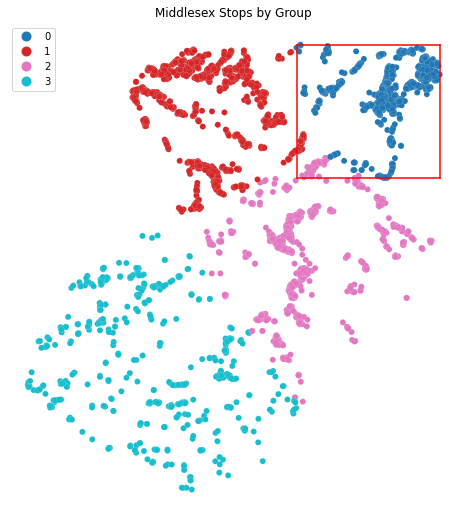

In [4]:
# Categorize target roadways using K-mean
num_group = 4

Middlesex_target_pts = gpd.GeoDataFrame(Middlesex_target_pts, columns=['geometry'])
training_data = np.concatenate((Middlesex_target_pts['geometry'].x.values.reshape(-1, 1), Middlesex_target_pts['geometry'].y.values.reshape(-1, 1)), axis=1)

km5 = cluster.KMeans(n_clusters=num_group)
km5cls = km5.fit(training_data)

Middlesex_target_pts['group'] = km5cls.labels_

# f, ax = plt.subplots(1, figsize=(18, 12))
# Monmouth_target_roadway_mids.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True,linewidth=0.1, edgecolor='white', ax=ax)
# ax.set_axis_off()
# plt.title("Monmouth County Target Roadway by Group")
# plt.show()

# visualize focal area & bounding box
transformer = Transformer.from_crs(3424, 4326, always_xy=True)

focal_group = 0

boundings_3424 = Middlesex_target_pts.loc[Middlesex_target_pts['group'] == focal_group, 'geometry'].total_bounds
boundings_4326_min = transformer.transform(boundings_3424[0], boundings_3424[1])
boundings_4326_max = transformer.transform(boundings_3424[2], boundings_3424[3])
boundings_4326 = np.concatenate([np.array(boundings_4326_min), np.array(boundings_4326_max)])

bbox = ((boundings_3424[0], boundings_3424[1]),
        (boundings_3424[0], boundings_3424[3]),
        (boundings_3424[2], boundings_3424[3]),
        (boundings_3424[2], boundings_3424[1]),
        (boundings_3424[0], boundings_3424[1]))

f, ax = plt.subplots(1, figsize=(9, 9))
for i in range(len(bbox)-1):
    plt.plot((bbox[i][0], bbox[i+1][0]), (bbox[i][1], bbox[i+1][1]), color='red')
Middlesex_target_pts.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True,linewidth=0.1, edgecolor='white', ax=ax)
ax.set_axis_off()
plt.title("Middlesex Stops by Group")
plt.show()

In [146]:
Middlesex_target_roadway_by_grp = pd.concat([Middlesex_target_roadway[['OBJECTID', 'geometry']], Middlesex_target_pts['group']], axis=1)
Middlesex_target_roadway_by_grp.head()

,OBJECTID,geometry,group
0,426772,"LINESTRING (484868.910 579120.730, 484941.590 ...",3
1,51467,"LINESTRING (561743.144 642540.880, 561743.630 ...",0
2,314480,"LINESTRING (498883.820 625239.290, 498891.740 ...",1
3,291874,"LINESTRING (537343.920 611064.290, 537230.430 ...",2
4,54755,"LINESTRING (558474.520 635897.340, 558726.727 ...",0


In [5]:
# get the Monmouth roadway network within the focal area
# G = ox.graph_from_bbox(boundings_4326[3], boundings_4326[1], boundings_4326[2], boundings_4326[0], network_type='drive') # ymax, ymin, xmax, xmin
# nodes, edges = ox.graph_to_gdfs(G)
# G_projected = ox.project_graph(G)
# ox.plot_graph(G_projected)

In [7]:
Middlesex_roadway = gpd.read_file("Middlesex_roadway_split_for_network.shp")
Middlesex_roadway.head()

,OBJECTID,SEG_GUID,PRIME_NAME,ADDR_L_FR,ADDR_L_TO,ADDR_R_FR,ADDR_R_TO,ZIPCODE_L,ZIPCODE_R,ZIPNAME_L,...,H3_NAME,H3_SHLD,H3_SUBSHLD,H3_NUM,FEATSTATUS,UPDATEDATE,SHAPE_Leng,Miles,Shape_Le_1,geometry
0,142238,{2D7112F0-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08902,08902,NORTH BRUNSWICK,...,None,None,None,None,D,2016-01-07,41.402881,0.007841,41.402928,"LINESTRING (504528.177 593881.858, 504487.991 ..."
1,286769,{3581432A-1708-11E3-B5F2-0062151309FF},None,0,0,0,0,08901,08901,NEW BRUNSWICK,...,None,None,None,None,F,2013-10-28,126.915547,0.024037,126.914551,"LINESTRING (512217.850 598227.810, 512238.769 ..."
2,54753,{21C4FCA0-1708-11E3-B5F2-0062151309FF},Wood Ave,469,489,474,498,08820,08830,EDISON,...,None,None,None,None,F,2014-06-10,252.426541,0.047808,252.426484,"LINESTRING (537450.150 636833.640, 537439.250 ..."
3,151874,{2842E4AC-1708-11E3-B5F2-0062151309FF},Vaughn Ave,47,17,54,18,08884,08884,SPOTSWOOD,...,None,None,None,None,F,2014-06-09,488.905987,0.092596,488.905925,"LINESTRING (522904.200 571226.700, 522950.304 ..."
4,390683,{34F4D12E-1708-11E3-B5F2-0062151309FF},Snapper Ave,22,98,21,99,08882,08882,SOUTH RIVER,...,None,None,None,None,F,2014-06-04,267.283555,0.050622,267.283660,"LINESTRING (522115.040 588432.190, 521940.244 ..."


# construct network from geodataframe

In [64]:
total_edges = len(Middlesex_roadway)

Nodes_set = set()
Roadway_Nodes = pd.DataFrame(columns=['OBJECTID', 'geometry'])
Roadway_Edges = pd.DataFrame(index=Middlesex_roadway.index, columns=['OBJECTID', 'nodes', 'length'])

n = 0

for i in Middlesex_roadway.index:
    node_pair = []
    line = Middlesex_roadway.loc[i, 'geometry']
    for pts in (line.coords[0], line.coords[-1]):
        if not pts in Nodes_set:
            temp_df = pd.DataFrame({n:{'OBJECTID': Middlesex_roadway.loc[i, 'OBJECTID'], 'geometry': pts}}).T
            Roadway_Nodes = pd.concat([Roadway_Nodes, temp_df], axis=0)
            n += 1
            Nodes_set.add(pts)
        node_pair.append(Roadway_Nodes.loc[Roadway_Nodes['geometry'] == pts, :].index[0])
        
    Roadway_Edges.loc[i, 'OBJECTID'] = Middlesex_roadway.loc[i, 'OBJECTID']
    Roadway_Edges.loc[i, 'nodes'] = tuple(node_pair)
    Roadway_Edges.loc[i, 'length'] = Middlesex_roadway.loc[i, 'geometry'].length
    
    print("progress: %d / %d" % (i, total_edges), end='\r')

In [65]:
Roadway_Edges

,OBJECTID,nodes,length
0,142238,"(0, 1)",41.402928
1,286769,"(2, 3)",126.914551
2,54753,"(4, 5)",252.426484
3,151874,"(6, 7)",488.905925
4,390683,"(8, 9)",267.28366
...,...,...,...
46683,87374,"(29975, 35729)",96.379882
46684,119059,"(22499, 33874)",35.820046
46685,202514,"(22010, 27704)",322.386213
46686,48564,"(3038, 26929)",481.881063


In [117]:
Roadway_Edges_new = Roadway_Edges.copy()
Roadway_Edges_new.insert(1, 'node_0', np.array([list(edge) for edge in Roadway_Edges['nodes']])[:, 0])
Roadway_Edges_new.insert(2, 'node_1', np.array([list(edge) for edge in Roadway_Edges['nodes']])[:, 1])
Roadway_Edges_new

,OBJECTID,node_0,node_1,nodes,length
0,142238,0,1,"(0, 1)",41.402928
1,286769,2,3,"(2, 3)",126.914551
2,54753,4,5,"(4, 5)",252.426484
3,151874,6,7,"(6, 7)",488.905925
4,390683,8,9,"(8, 9)",267.28366
...,...,...,...,...,...
46683,87374,29975,35729,"(29975, 35729)",96.379882
46684,119059,22499,33874,"(22499, 33874)",35.820046
46685,202514,22010,27704,"(22010, 27704)",322.386213
46686,48564,3038,26929,"(3038, 26929)",481.881063


In [118]:
Roadway_network = nx.from_pandas_edgelist(Roadway_Edges_new, 'node_0', 'node_1', edge_attr='length')
Roadway_network

In [120]:
Roadway_network[0][1]

{'length': 41.4029280206631}

# Process target roadways

In [121]:
Roadway_Nodes_new = Roadway_Nodes.copy()
Roadway_Nodes_new = gpd.GeoDataFrame(Roadway_Nodes_new, crs="EPSG:3424")
Roadway_Nodes_new['geometry'] = [Point(pts) for pts in Roadway_Nodes_new['geometry']]
type(Roadway_Nodes_new)

geopandas.geodataframe.GeoDataFrame

In [133]:
target_roadway_raw = gpd.sjoin(Middlesex_target_roadway, Roadway_Nodes_new, how='left', op='intersects').reset_index(drop=True)
target_roadway_raw.head()

,OBJECTID_left,SEG_GUID,PRIME_NAME,ADDR_L_FR,ADDR_L_TO,ADDR_R_FR,ADDR_R_TO,ZIPCODE_L,ZIPCODE_R,ZIPNAME_L,...,H3_SUBSHLD,H3_NUM,FEATSTATUS,UPDATEDATE,SHAPE_Leng,Miles,Shape_Le_1,geometry,index_right,OBJECTID_right
0,426772,{294BD84A-1708-11E3-B5F2-0062151309FF},US Hwy 1,0,0,3759,3749,08852,08824,MONMOUTH JUNCTION,...,None,None,F,2016-05-06,105.840191,0.020045,105.840270,"LINESTRING (484868.910 579120.730, 484941.590 ...",16712,142404
1,426772,{294BD84A-1708-11E3-B5F2-0062151309FF},US Hwy 1,0,0,3759,3749,08852,08824,MONMOUTH JUNCTION,...,None,None,F,2016-05-06,105.840191,0.020045,105.840270,"LINESTRING (484868.910 579120.730, 484941.590 ...",13914,63528
2,51467,{069F71E4-1708-11E3-B5F2-0062151309FF},Dalbert St,0,0,0,0,07008,07008,CARTERET,...,None,None,F,2014-06-09,166.447331,0.031524,166.447222,"LINESTRING (561743.144 642540.880, 561743.630 ...",14603,43132
3,51467,{069F71E4-1708-11E3-B5F2-0062151309FF},Dalbert St,0,0,0,0,07008,07008,CARTERET,...,None,None,F,2014-06-09,166.447331,0.031524,166.447222,"LINESTRING (561743.144 642540.880, 561743.630 ...",17897,246528
4,314480,{104A9E12-1708-11E3-B5F2-0062151309FF},OLD New Brunswick Rd,0,0,279,251,08854,08854,PISCATAWAY,...,None,None,F,2016-05-06,43.969181,0.008327,43.969143,"LINESTRING (498883.820 625239.290, 498891.740 ...",12117,139858


In [138]:
Target_Roadway_df = pd.DataFrame(index=target_roadway_raw['OBJECTID_left'].unique(), columns=['nodes', 'length'])

for edge_ix in Target_Roadway_df.index:
    temp = target_roadway_raw.loc[target_roadway_raw['OBJECTID_left'] == edge_ix, :]
    node_lst = []
    for node_ix in temp.index:
        node_lst.append(temp.loc[node_ix, 'index_right'])
        length = temp.loc[node_ix, 'geometry'].length
    Target_Roadway_df.loc[edge_ix, 'nodes'] = node_lst
    Target_Roadway_df.loc[edge_ix, 'length'] = length

Target_Roadway_df

,nodes,length
426772,"[16712, 13914]",105.84027
51467,"[14603, 17897]",166.447222
314480,"[12117, 29618]",43.969143
291874,"[10032, 9021]",412.89705
54755,"[26953, 26952]",257.785909
...,...,...
297114,"[22643, 22642]",174.423523
202190,"[10762, 7240]",535.600947
393378,"[32147, 13751]",166.125482
272097,"[26313, 26312]",608.500784


In [147]:
Target_edges_by_grp = Middlesex_target_roadway_by_grp.loc[Middlesex_target_roadway_by_grp['group']==focal_group, :]
Target_edges_by_grp

,OBJECTID,geometry,group
1,51467,"LINESTRING (561743.144 642540.880, 561743.630 ...",0
4,54755,"LINESTRING (558474.520 635897.340, 558726.727 ...",0
13,63611,"LINESTRING (570228.020 636641.370, 570215.610 ...",0
14,485383,"LINESTRING (567099.210 637368.500, 567322.910 ...",0
31,95875,"LINESTRING (558872.461 627108.107, 558819.360 ...",0
...,...,...,...
4424,34939,"LINESTRING (567388.760 640807.428, 567396.498 ...",0
4426,255429,"LINESTRING (566541.534 643259.087, 566537.410 ...",0
4429,432596,"LINESTRING (555257.400 628918.602, 555239.600 ...",0
4432,186227,"LINESTRING (548931.660 638632.710, 548814.320 ...",0


# Construct complete graph for the focal edges (roadways)